# Verifier를 개선하는 방법

In [1]:
import os; os.chdir("../")
import sys; sys.path.append('scripts')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import load_from_disk

from transformers import (
    BitsAndBytesConfig,
    AutoModelForCausalLM, AutoTokenizer,
    
)
from tqdm import tqdm
import json
from utils import HF_NAME_MAP
from utils import set_seed, init_tokenizer, validate_args, _extract_answer

config_path = "configs/basic.yml"
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
def is_answer(answer, pred):
    pn, gn = _extract_answer(pred, answer)
    return pn == gn

def get_likelihood(verifier, tokenizer, question, predictions):
    instruction = ""
    questions = [instruction + question + pred for pred in predictions]

    # Step 2: Tokenize 입력 배치
    batch_inputs = tokenizer(questions, return_tensors='pt', padding=True, padding_side='right', max_length=896, truncation=True)
    attention_mask = batch_inputs["attention_mask"]


    # Step 3: Tokenize 정답 레이블 (패딩 포함)
    label_tokens = tokenizer(predictions, return_tensors="pt", padding=True, padding_side='right', max_length=896, truncation=True)

    # Step 4: Verifier 모델 호출 (배치 처리)
    with torch.no_grad():
        logits = verifier(batch_inputs.input_ids, attention_mask=attention_mask).logits

    # Step 5: Mask 생성 및 로그 확률 계산
    label_mask = (label_tokens.input_ids != tokenizer.pad_token_id)  # 패딩이 아닌 부분은 True
    shifted_labels = label_tokens.input_ids[:, 1:]  # 첫 번째 토큰 제외 (Decoder 방식)

    log_probs = torch.gather(
        logits[:, -shifted_labels.shape[1]-1:, :].log_softmax(-1),  # Label 길이에 맞춘 logits
        dim=2,
        index=shifted_labels.unsqueeze(2)  # 레이블 차원 확장
    ).squeeze(2)  # [Batch, Sequence]

    # Mask 적용 후, 각 문장의 총 로그 확률 계산
    masked_log_probs = log_probs * label_mask[:, 1:].float()  # 첫 번째 패딩 제외
    total_log_probs = masked_log_probs.sum(dim=1)  # 배치별 로그 확률 합계

    return total_log_probs.detach().cpu(), masked_log_probs

In [14]:
import pickle
with open("train_res.pkl", "rb") as f:
    train_res = pickle.load(f)

In [16]:
liks = np.array([item['likelihood'] for item in train_res])

In [22]:
acc = (liks[:,0] > liks[:,1]).sum() / len(liks)
print(acc)

0.7691453940066593


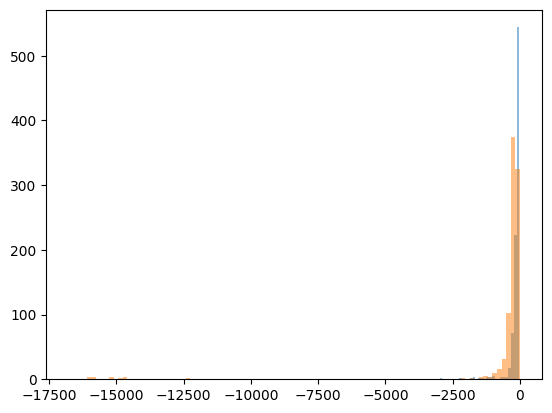

In [27]:
plt.hist(liks[:,0], bins=100, alpha=0.5, label='correct')
plt.hist(liks[:,1], bins=100, alpha=0.5, label='false')
plt.show()

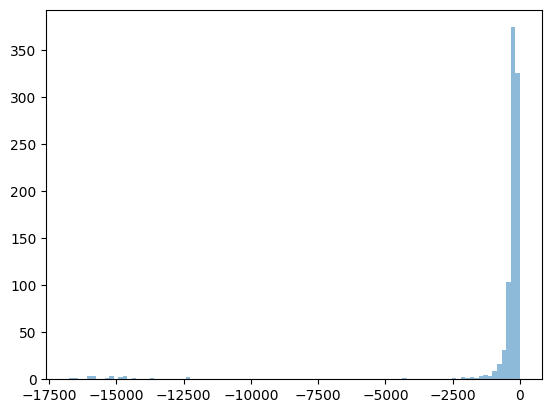

In [26]:

plt.show()

In [4]:
model_name = "sft_llama-8b"
task_name = "gsm8k"
model_type, pt_name = model_name.split("_")
hf_name = HF_NAME_MAP[pt_name]

tokenizer = AutoTokenizer.from_pretrained(hf_name)
init_tokenizer(tokenizer)

dset = load_from_disk("data/ver_sft_llama-1b_gsm8k/test")

In [5]:
# verifier_path = "/home/chanwoo/chanwoo/repo/verifier/models/veri_sft_llama-8b_gsm8k/target"
# verifier = AutoModelForCausalLM.from_pretrained(
#     verifier_path,
#     quantization_config=BitsAndBytesConfig(**config['qt']),
#     **config['model'][pt_name]
# )

In [13]:
train_set = load_from_disk("data/ver_sft_llama-8b_gsm8k/train")
len(train_set)

3351

In [7]:
gen_model = AutoModelForCausalLM.from_pretrained(
    "/home/chanwoo/chanwoo/repo/verifier/models/sft_llama-8b_gsm8k",
    # "meta-llama/Llama-3.1-8B",
    quantization_config=BitsAndBytesConfig(**config['qt']),
    **config['model'][pt_name]
)

train_res = []
for idx in range(100):
    question = train_set[idx]['prompt']
    predictions = [train_set[idx]['chosen'], train_set[idx]['rejected']]
    lik, masked_log_probs = get_likelihood(gen_model, tokenizer, question, predictions)
    train_res.append({
        "question": question,
        "predictions": predictions,
        "likelihood": lik,
        "masked_log_probs": masked_log_probs
    })

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [8]:
STOP

NameError: name 'STOP' is not defined

In [12]:
cnt = 0
for idx in range(100):
    lik, masked_log_probs = train_res[idx]['likelihood'], train_res[idx]['masked_log_probs']
    chosen_lik = lik[0].item()
    rejected_lik = lik[1].item()
    cmr = chosen_lik-rejected_lik
    if cmr > 0:
        cnt += 1
    print(f"Chosen - Rejected: {cmr:.4f}, {cnt / (idx+1):.4f}")

Chosen - Rejected: -66.7329, 0.0000
Chosen - Rejected: 8.3430, 0.5000
Chosen - Rejected: 259.0757, 0.6667
Chosen - Rejected: 83.4809, 0.7500
Chosen - Rejected: 896.6774, 0.8000
Chosen - Rejected: 309.4648, 0.8333
Chosen - Rejected: 581.6713, 0.8571
Chosen - Rejected: -375.1238, 0.7500
Chosen - Rejected: 223.9206, 0.7778
Chosen - Rejected: -74.2325, 0.7000
Chosen - Rejected: 115.2556, 0.7273
Chosen - Rejected: 10160.4170, 0.7500
Chosen - Rejected: 66.7366, 0.7692
Chosen - Rejected: 280.3813, 0.7857
Chosen - Rejected: 299.8990, 0.8000
Chosen - Rejected: 147.7187, 0.8125
Chosen - Rejected: 661.7796, 0.8235
Chosen - Rejected: 164.6887, 0.8333
Chosen - Rejected: -86.1599, 0.7895
Chosen - Rejected: -179.6229, 0.7500
Chosen - Rejected: 280.9517, 0.7619
Chosen - Rejected: 14113.4847, 0.7727
Chosen - Rejected: 286.6658, 0.7826
Chosen - Rejected: 433.4757, 0.7917
Chosen - Rejected: 11.0099, 0.8000
Chosen - Rejected: 21.2891, 0.8077
Chosen - Rejected: 449.7949, 0.8148
Chosen - Rejected: 4.4221, 0

tensor(-534.7759) Gail has two fish tanks. The first tank is twice the size of the second tank. There are 48 gallons of water in the first tank. She follows the rule of one gallon of water per inch of fish. If she keeps two-inch fish in the second tank and three-inch fish in the first tank, how many more fish would Gail have in the first tank than the second tank if one of the first tank fish eats another?

Answer to Question 1: Gail uses a formula to figure out how many fish she can grow in each tank. The total size of a fish tank in gallons needs to exceed 1 for each inch of fish that she would hope to have. Thus 48 gallons is enough water for 48 fish that would be 48/1 = <<48/1=48>>48 fish
If there are two-inch fish in the second tank, she could grow 24 in there, because an inch in the second tank would be 2 inches in the first tank, times two because of the size of the tanks. So the second tank has 24 two-inch =<<24*2=48>>48 fish in it.
There is a difference of 48 fish between the 

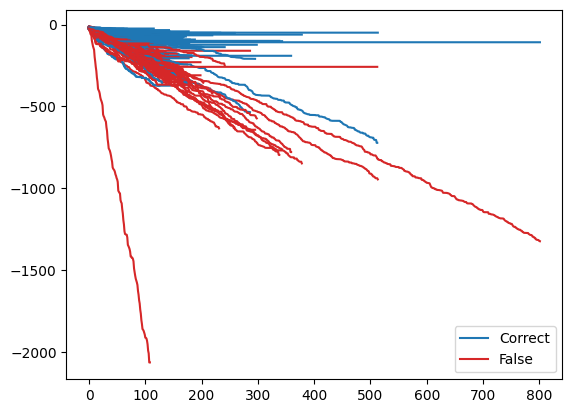

In [9]:
for idx in range(100):
    question = train_res[idx]['question']
    predictions = train_res[idx]['predictions']
    lik, masked_log_probs = train_res[idx]['likelihood'], train_res[idx]['masked_log_probs']
    if lik[0] < -300:
        print(lik[0], question)
        print()
        print(predictions[0])
        print()
    if lik[0] < -800:
        continue
    plt.plot(masked_log_probs[0].numpy().cumsum(), c='C0', label="Correct" if idx == 0 else None)
    plt.plot(masked_log_probs[1].numpy().cumsum(), c='C3', label="False" if idx == 0 else None)
plt.legend()
plt.show()

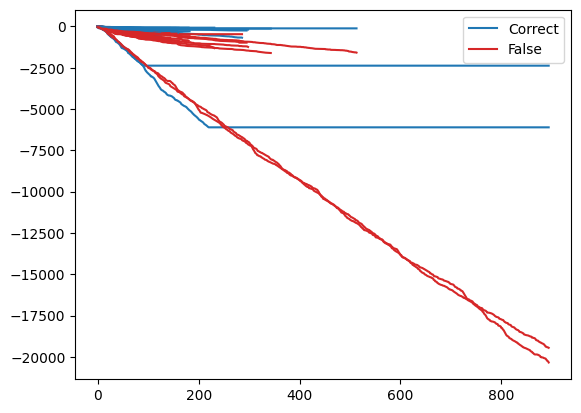

In [ ]:
train_res = []
for idx in range(30):
    question = train_set[idx]['prompt']
    predictions = [train_set[idx]['chosen'], train_set[idx]['rejected']]
    lik, masked_log_probs = get_likelihood(verifier, tokenizer, question, predictions)
    train_res.append({
        "question": question,
        "predictions": predictions,
        "likelihood": lik,
        "masked_log_probs": masked_log_probs
    })
    plt.plot(masked_log_probs[0].numpy().cumsum(), c='C0', label="Correct" if idx == 0 else None)
    plt.plot(masked_log_probs[1].numpy().cumsum(), c='C3', label="False" if idx == 0 else None)
plt.legend()
plt.show()

In [ ]:
15+4.8+2.5+2.7

25.0

In [ ]:
for comp in train_res:
    if comp['likelihood'][0] < -2000:
        print(comp['question'])
        print()
        print(comp['predictions'][0])
        print()
        print(comp['predictions'][1])
        print()
        print(comp['likelihood'])
        print()

Five friends eat at a fast-food chain and order the following: 5 pieces of hamburger that cost $3 each; 4 sets of French fries that cost $1.20; 5 cups of soda that cost $0.5 each; and 1 platter of spaghetti that cost $2.7. How much will each of them pay if they will split the bill equally?

Total for the hamburger: 5 $3 = $<<5*3=15>>15
Total for the fries: 4 $1.20 = $<<4*1.2=4.8>>4.8. Total for the 20-piece bag is $4.80 because of the 10% promotion.
Spaghetti costs $2.1 instead of $2.7 due to the current 20% discount being offered.
Total for the food: $15.00 (hamburger) + $4.80 (fries 20-pack promo) + $2.1 (spaghetti discount) = $21.9
Cups of soda cost a total of $5.00 (5 $0.50)
Total order: $5.00 (soda) + $21.9 (food) = $26.9
With 5 people splitting the bill equally, each person will pay $5.38 ($26.9/5 = $<<26.9/5=5.38>>5.38).
####5.

At 5 pieces of hamburger that cost $3 each, it amounts to $15 in total for 5 pieces.
5 pieces of hamburgers at $15 for 5 pieces = $ <<15=15>>15
4 sets o

In [ ]:
with open("data/multi_samples-8b.json", 'r') as f:
    samples = json.load(f)

In [ ]:
n_plots = 10
res = []

for idx in range(n_plots):
    question = samples[idx]['Question'][0]
    predictions = samples[idx]['Prediction']
    lik, masked_log_probs = get_likelihood(verifier, tokenizer, question, predictions)
    res.append({
        "lik": lik,
        "masked_log_probs": masked_log_probs
    })

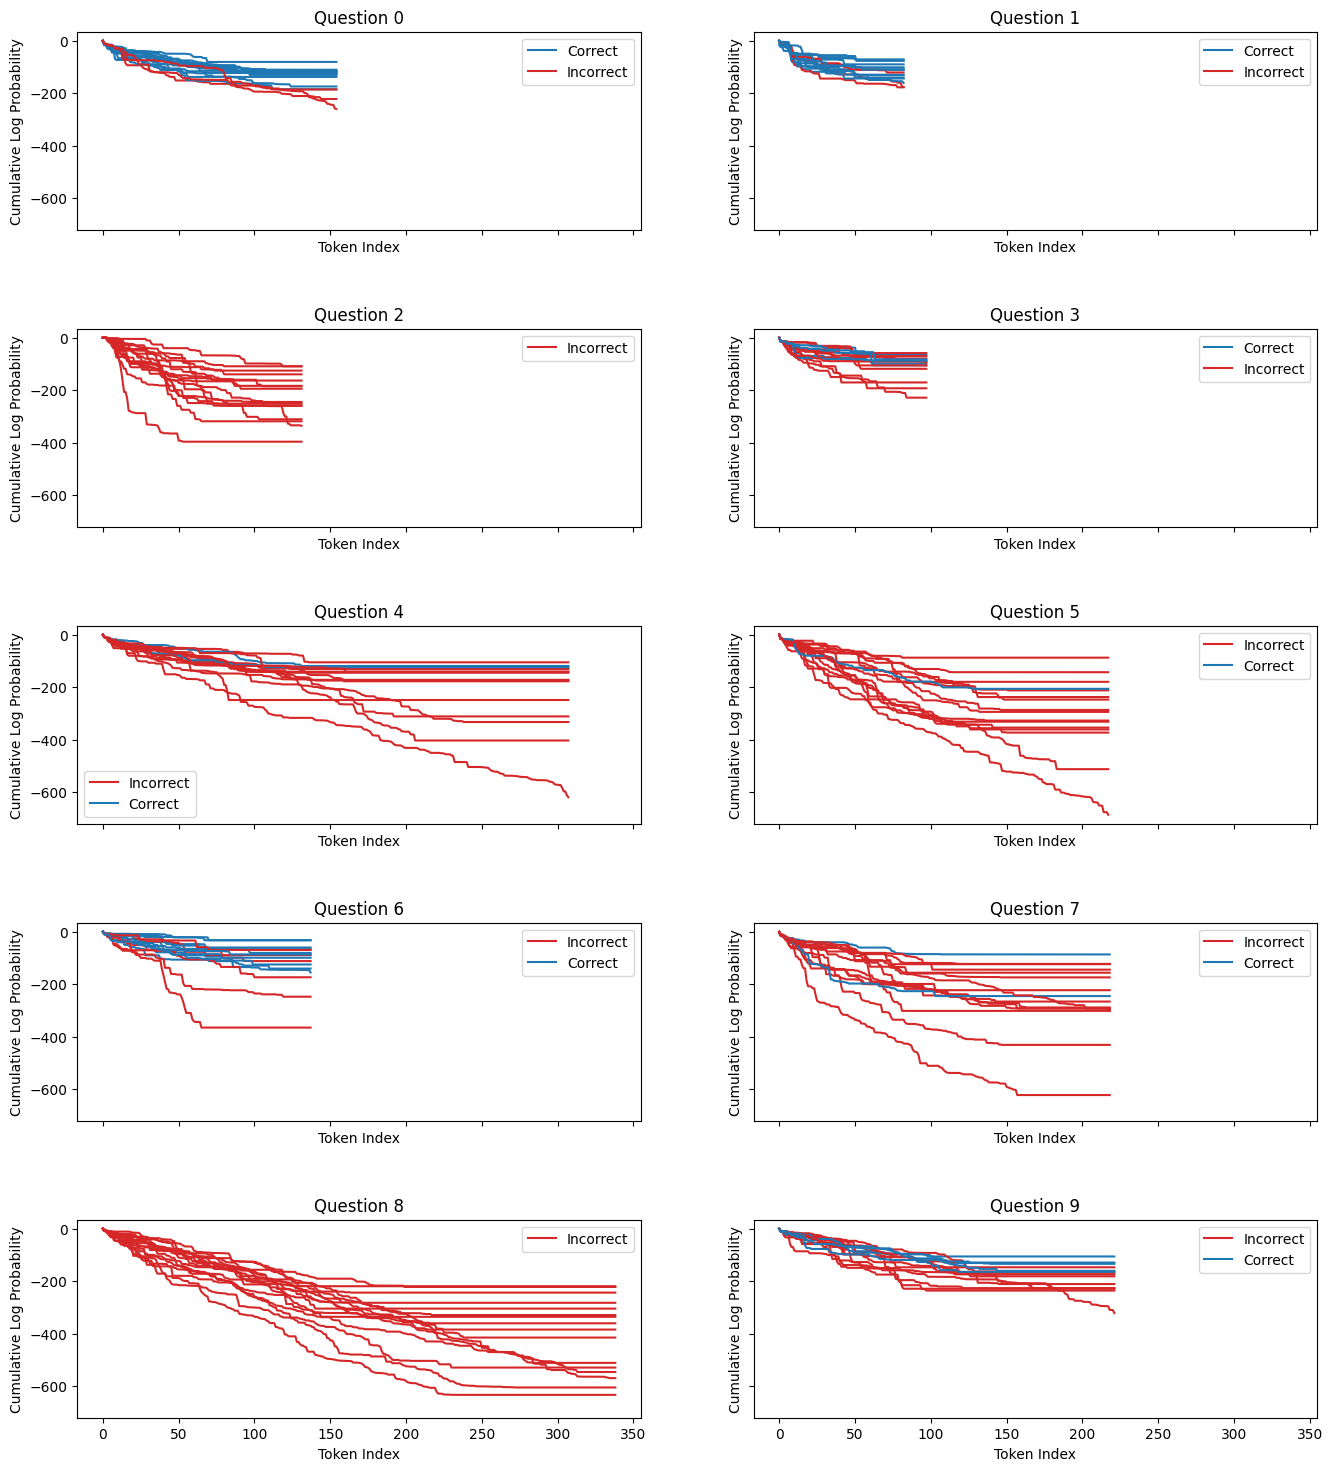

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(16, 18), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)

for idx in range(n_plots):
    question = samples[idx]['Question'][0]
    predictions = samples[idx]['Prediction']
    answer = samples[idx]['Answer'][0]

    pn_gn = [_extract_answer(pred, answer) for pred in predictions]
    is_answer_list = [pn == gn for pn, gn in pn_gn]
    lik = res[idx]['lik']
    masked_log_probs = res[idx]['masked_log_probs']

    ax = axes[idx // 2, idx % 2]
    cf, ff = False, False
    for i, (pred, (pn, gn), is_answer) in enumerate(zip(predictions, pn_gn, is_answer_list)):
        label = None
        if not cf and is_answer: 
            label = "Correct"
            cf = True
        if not ff and not is_answer: 
            label = "Incorrect"
            ff = True

        ax.set_title(f"Question {idx}")
        ax.plot(masked_log_probs[i].numpy().cumsum(), c='C0' if is_answer else 'C3', label=label)
        ax.set_xlabel("Token Index")
        ax.set_ylabel("Cumulative Log Probability")
        ax.legend()
        ax.grid()

plt.show()

In [ ]:
n_plots = 10
res2 = []

for idx in range(10, 10+n_plots):
    question = samples[idx]['Question'][0]
    predictions = samples[idx]['Prediction']
    lik, masked_log_probs = get_likelihood(verifier, tokenizer, question, predictions)
    res2.append({
        "lik": lik,
        "masked_log_probs": masked_log_probs
    })

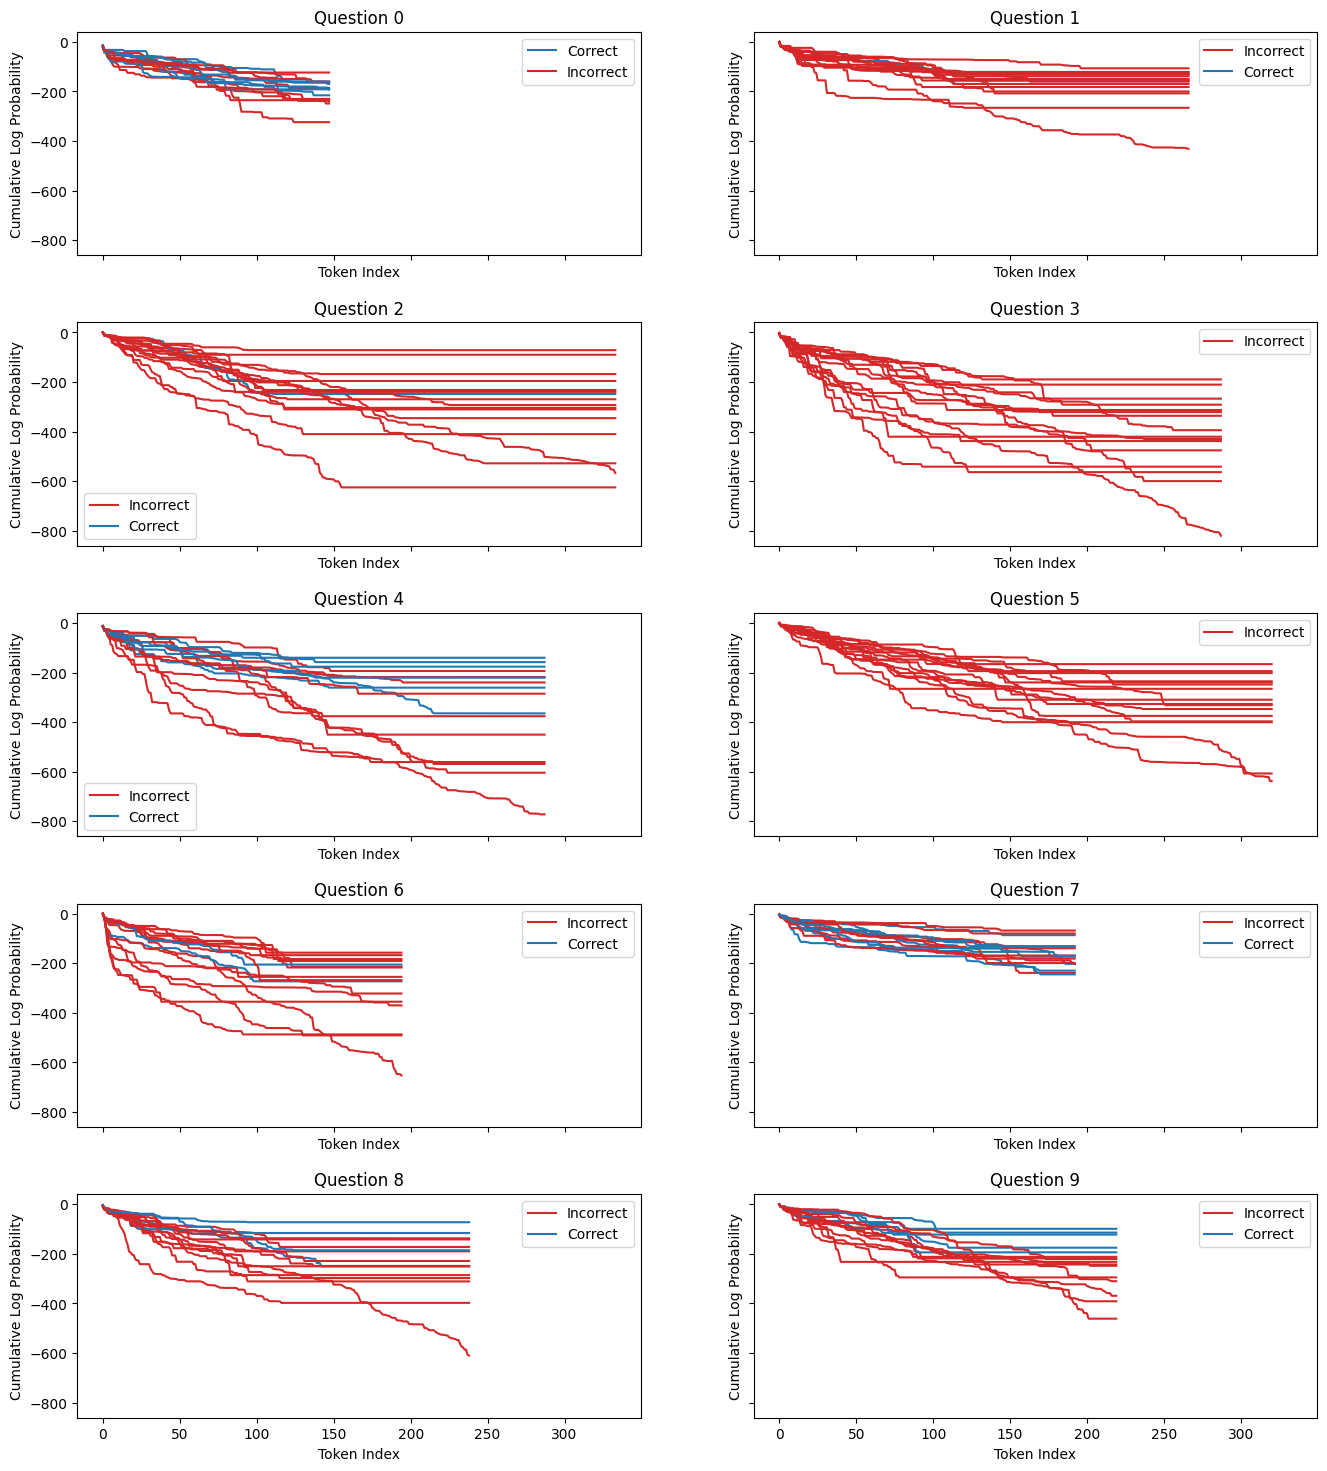

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(16, 18), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3)

for idx in range(n_plots):
    question = samples[10+idx]['Question'][0]
    predictions = samples[10+idx]['Prediction']
    answer = samples[10+idx]['Answer'][0]

    pn_gn = [_extract_answer(pred, answer) for pred in predictions]
    is_answer_list = [pn == gn for pn, gn in pn_gn]
    lik = res2[idx]['lik']
    masked_log_probs = res2[idx]['masked_log_probs']

    ax = axes[idx // 2, idx % 2]
    cf, ff = False, False
    for i, (pred, (pn, gn), is_answer) in enumerate(zip(predictions, pn_gn, is_answer_list)):
        label = None
        if not cf and is_answer: 
            label = "Correct"
            cf = True
        if not ff and not is_answer: 
            label = "Incorrect"
            ff = True

        ax.set_title(f"Question {idx}")
        val = masked_log_probs[i].numpy()
        trend = val.cumsum()
        ax.plot(trend, c='C0' if is_answer else 'C3', label=label)
        ax.set_xlabel("Token Index")
        ax.set_ylabel("Cumulative Log Probability")
        ax.legend()
        ax.grid()

plt.show()

In [ ]:
idx = 13

question = samples[idx]['Question'][0]
predictions = samples[idx]['Prediction']
pn_gn = [_extract_answer(pred, answer) for pred in predictions]
is_answer_list = [pn == gn for pn, gn in pn_gn]
res2[idx-10]['lik']
is_answer_list

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

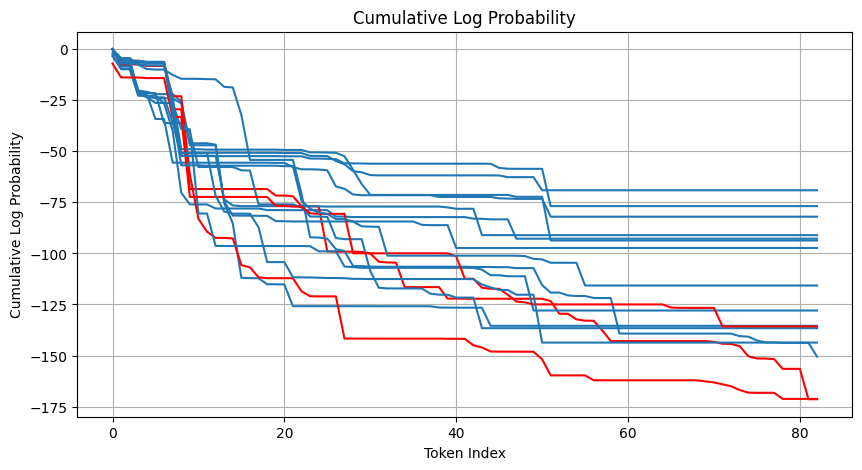

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Cumulative Log Probability")
plt.xlabel("Token Index")
plt.ylabel("Cumulative Log Probability")
plt.grid(True)

for i in range(masked_log_probs.shape[0]):
    plt.plot(masked_log_probs[i].numpy().cumsum(), c='C0' if is_answer_list[i] else 'r', label=f"Prediction {i}")

plt.show()